### Importing  necessary modules and libraries

In [185]:
# These are standard python modules
import json, time, urllib.parse, copy
#
# The 'requests' module is not a standard Python module. You will need to install this with pip/pip3 if you do not already have it
import requests
#
# The pandas module is used to read and write data files like the csv
import pandas as pd

# The pandas module is used to create graphs to visualize the data
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

#random module is used to pick a color at random for dynamic visualizations
import random

### Reading the rare disease cleaned input file

In [3]:
rare_disease_df = pd.read_csv("./rare-disease_cleaned.AUG.2024.csv")

### Data acquisition

In [92]:
# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED


# Set the start and end dates in YYYYMMDDHH format
START_DATE = "2015010100"
END_DATE = "2024100100"

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error 
REQUEST_HEADERS = {
    'User-Agent': 'rohitch@uw.edu, University of Washington, MSDS DATA 512 - AUTUMN 2024',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
ARTICLE_TITLES = rare_disease_df['disease']

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "",      # this should be changed for the different access types
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       START_DATE,
    "end":         END_DATE
}


In [16]:
#function to call the wikimedia API and return the views monthwise as a json response
def request_pageviews_per_article(article_title = None, 
                                  access = "desktop",
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    # access type to be set a parameter to the call
    if access:
        request_template['access'] = access

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'), safe='')
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

### Fetch monthly desktop access

In [98]:
monthly_desktop_access = {}
for title in ARTICLE_TITLES:
    response = request_pageviews_per_article(
        article_title = title,
        access = "desktop",
    )
    views = response['items']
    # remove the unrequired fields like article, as it will be the key of the json object, access as it is confusing for the mobile views
    for view in views:
        del view['article']
        del view['access']
    
    print(title, " Done")
    monthly_desktop_access[title] = views


Klinefelter syndrome  Done
Aarskog–Scott syndrome  Done
Abetalipoproteinemia  Done
MT-TP  Done
Ablepharon macrostomia syndrome  Done
Acanthocheilonemiasis  Done
Acanthosis nigricans  Done
Aceruloplasminemia  Done
Megaesophagus  Done
Achard–Thiers syndrome  Done
Achondrogenesis  Done
Achondroplasia  Done
Dwarfism  Done
Osteochondrodysplasia  Done
Fibroblast growth factor receptor 3  Done
Vestibular schwannoma  Done
Brain tumor  Done
Acquired generalized lipodystrophy  Done
Barraquer–Simons syndrome  Done
Acrodermatitis enteropathica  Done
Zinc deficiency  Done
Brown-Séquard syndrome  Done
Spinal cord injury  Done
Brucellosis  Done
Yellowstone Park bison herd  Done
Māui dolphin  Done
Brugada syndrome  Done
Nav1.8  Done
Sports cardiology  Done
Budd–Chiari syndrome  Done
Thrombosis  Done
Hepatic veno-occlusive disease  Done
Thromboangiitis obliterans  Done
Bullous pemphigoid  Done
Pemphigoid  Done
Trigonocephaly  Done
CADASIL  Done
Campomelic dysplasia  Done
Camurati–Engelmann disease  Don

### Write monthly desktop access data to respective json file

In [101]:
start_date_from_data = monthly_desktop_access[list(monthly_desktop_access.keys())[0]][0]['timestamp'][0:6]
end_date_from_data = monthly_desktop_access[list(monthly_desktop_access.keys())[0]][-1]['timestamp'][0:6]
filename = f"rare-disease_monthly_desktop_{start_date_from_data}-{end_date_from_data}.json"

print(filename)
with open(filename, "w") as outfile: 
    outfile.write(json.dumps(monthly_desktop_access, indent=4))

rare-disease_monthly_desktop_201507-202407.json


### Fetch monthly mobile access (mobile-app and mobile-web)

In [66]:
monthly_mobile_access = {}
for title in ARTICLE_TITLES:
    response_mobile_app = request_pageviews_per_article(
        article_title = title,
        access = "mobile-app",
    )

    response_mobile_web = request_pageviews_per_article(
    article_title = title,
    access = "mobile-web",
    )

    views_mobile_app = response_mobile_app['items']
    views_mobile_web = response_mobile_web['items']
    # remove the unrequired fields like article, as it will be the key of the json object, access as it is confusing for the mobile views
    for index, view in enumerate(views_mobile_app):
        del view['article']
        del view['access']

        #combining views from both mobile app and mobile web
        view['views'] = view['views'] + views_mobile_web[index]['views']

    
    print(title, " Done")
    monthly_mobile_access[title] = views_mobile_app

Klinefelter syndrome  Done
Aarskog–Scott syndrome  Done
Abetalipoproteinemia  Done
MT-TP  Done
Ablepharon macrostomia syndrome  Done
Acanthocheilonemiasis  Done
Acanthosis nigricans  Done
Aceruloplasminemia  Done
Megaesophagus  Done
Achard–Thiers syndrome  Done
Achondrogenesis  Done
Achondroplasia  Done
Dwarfism  Done
Osteochondrodysplasia  Done
Fibroblast growth factor receptor 3  Done
Vestibular schwannoma  Done
Brain tumor  Done
Acquired generalized lipodystrophy  Done
Barraquer–Simons syndrome  Done
Acrodermatitis enteropathica  Done
Zinc deficiency  Done
Brown-Séquard syndrome  Done
Spinal cord injury  Done
Brucellosis  Done
Yellowstone Park bison herd  Done
Māui dolphin  Done
Brugada syndrome  Done
Nav1.8  Done
Sports cardiology  Done
Budd–Chiari syndrome  Done
Thrombosis  Done
Hepatic veno-occlusive disease  Done
Thromboangiitis obliterans  Done
Bullous pemphigoid  Done
Pemphigoid  Done
Trigonocephaly  Done
CADASIL  Done
Campomelic dysplasia  Done
Camurati–Engelmann disease  Don

### Write monthly mobile access data to respective json file

In [104]:
start_date_from_data = monthly_mobile_access[list(monthly_mobile_access.keys())[0]][0]['timestamp'][0:6]
end_date_from_data = monthly_mobile_access[list(monthly_mobile_access.keys())[0]][-1]['timestamp'][0:6]
filename = f"rare-disease_monthly_mobile_{start_date_from_data}-{end_date_from_data}.json"

print(filename)
with open(filename, "w") as outfile: 
    outfile.write(json.dumps(monthly_mobile_access, indent=4))

rare-disease_monthly_mobile_201507-202407.json


### Combining the monthly views by summing both desktop and mobile for every month

In [102]:
monthly_combined = copy.deepcopy(monthly_desktop_access)
for title, views in monthly_combined.items():
    for index, view in enumerate(views):

        #combining views from both desktop and mobile
        view['views'] = view['views'] + monthly_mobile_access[title][index]['views']

### Write monthly cumulative data to respective json file

In [105]:
start_date_from_data = monthly_combined[list(monthly_combined.keys())[0]][0]['timestamp'][0:6]
end_date_from_data = monthly_combined[list(monthly_combined.keys())[0]][-1]['timestamp'][0:6]
filename = f"rare-disease_monthly_cumulative_{start_date_from_data}-{end_date_from_data}.json"

print(filename)
with open(filename, "w") as outfile: 
    outfile.write(json.dumps(monthly_combined, indent=4))

rare-disease_monthly_cumulative_201507-202407.json


### Calculating minimum and maximum average views for desktop

In [107]:
desktop_average_views = {}
for title, views in monthly_desktop_access.items():
    total_views = 0
    for view in views:
        total_views += view['views']
    desktop_average_views[title] = total_views/len(views)

In [125]:
max_avg_desktop_title = max(desktop_average_views, key=desktop_average_views.get)
min_avg_desktop_title = min(desktop_average_views, key=desktop_average_views.get)
print("Page title with the maximum average views for DESKTOP is ", max_avg_desktop_title)
print("Page title with the minimum average views for DESKTOP is ", min_avg_desktop_title)

Page title with the maximum average views for DESKTOP is  Black Death
Page title with the minimum average views for DESKTOP is  Filippi Syndrome


### Calculating minimum and maximum average views for mobile

In [123]:
mobile_average_views = {}
for title, views in monthly_mobile_access.items():
    total_views = 0
    for view in views:
        total_views += view['views']
    mobile_average_views[title] = total_views/len(views)

In [132]:
max_avg_mobile_title = max(mobile_average_views, key=mobile_average_views.get)
min_avg_mobile_title = min(mobile_average_views, key=mobile_average_views.get)
print("Page title with the maximum average views for MOBILE is ", max_avg_mobile_title)
print("Page title with the minimum average views for MOBILE is ", min_avg_mobile_title)

Page title with the maximum average views for MOBILE is  Black Death
Page title with the minimum average views for MOBILE is  Filippi Syndrome


### Visualize maximum and minimum average page views

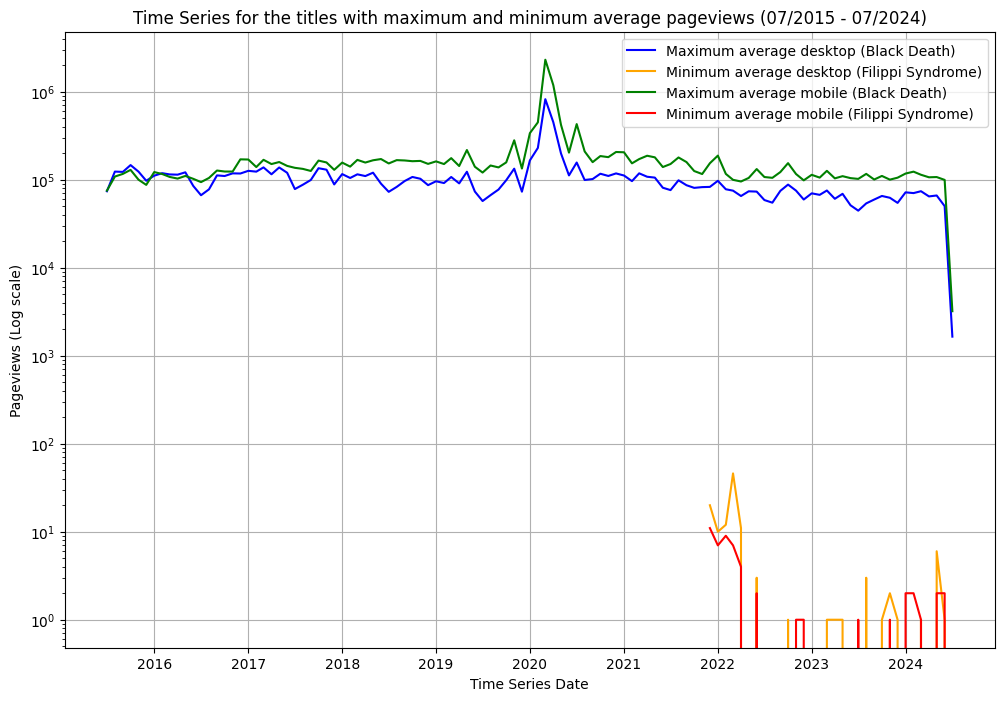

In [312]:
plt.figure(figsize=(12, 8))
plt.plot([pd.to_datetime(item['timestamp'][:6], format='%Y%m') for item in monthly_desktop_access[max_avg_desktop_title]], 
         [item['views'] for item in monthly_desktop_access[max_avg_desktop_title]],  
         linestyle='-', 
         color='b',
         label=f"Maximum average desktop ({max_avg_desktop_title})"
         )

plt.plot([pd.to_datetime(item['timestamp'][:6], format='%Y%m') for item in monthly_desktop_access[min_avg_desktop_title]], 
         [item['views'] for item in monthly_desktop_access[min_avg_desktop_title]], 
         linestyle='-', 
         color='orange',
         label=f"Minimum average desktop ({min_avg_desktop_title})"
         )

plt.plot([pd.to_datetime(item['timestamp'][:6], format='%Y%m') for item in monthly_mobile_access[max_avg_mobile_title]], 
         [item['views'] for item in monthly_mobile_access[max_avg_mobile_title]], 
         linestyle='-', 
         color='g',
         label=f"Maximum average mobile ({max_avg_mobile_title})"
         )

plt.plot([pd.to_datetime(item['timestamp'][:6], format='%Y%m') for item in monthly_mobile_access[min_avg_mobile_title]], 
         [item['views'] for item in monthly_mobile_access[min_avg_mobile_title]], 
         linestyle='-', 
         color='r',
         label=f"Minimum average mobile ({min_avg_mobile_title})"
         )

# log scale is used so that the extremes of the data can be visualized in the same graph without sqauishing the lower values
plt.yscale('log')
# Labels and title
plt.xlabel('Time Series Date')
plt.ylabel('Pageviews (Log scale)')
plt.title('Time Series for the titles with maximum and minimum average pageviews (07/2015 - 07/2024)')
plt.legend()
plt.grid(True)
plt.savefig("max_min_avg_logscale.png")
# Show the plot
plt.show()

### Analyze titles with top 10 page views across timestamps for Desktop and Mobile accesses

In [313]:
# Function to find top k titles with maximum views
def find_top_k_titles(data, k):
    # Sort the dictionary by values in descending order and get the top k views
    sorted_data = sorted(data.items(), key=lambda item: item[1], reverse=True)
    return sorted_data[:k]

def find_fewest_k_titles(data, k):
    # Sort the dictionary by values in increasing order of the fewest months of data
    sorted_data = sorted(data.items(), key=lambda item: item[1])
    return sorted_data[:k]

In [178]:
desktop_top_views_per_title = {}
for title, views in monthly_desktop_access.items():
    max_views_title = 0
    for view in views:
        if view['views'] > max_views_title:
            max_views_title = view['views']
    desktop_top_views_per_title[title] = max_views_title

desktop_top_10 = find_top_k_titles(desktop_top_views_per_title, 10)

mobile_top_views_per_title = {}
for title, views in monthly_mobile_access.items():
    max_views_title = 0
    for view in views:
        if view['views'] > max_views_title:
            max_views_title = view['views']
    mobile_top_views_per_title[title] = max_views_title

mobile_top_10 = find_top_k_titles(mobile_top_views_per_title, 10)

In [177]:
desktop_top_10

[('Pandemic', 1046521),
 ('Black Death', 823649),
 ('Chloroquine', 440897),
 ('Pfeiffer syndrome', 408153),
 ('Fibrodysplasia ossificans progressiva', 313785),
 ('Botulism', 302593),
 ('Robert Koch', 254656),
 ('Smallpox', 249177),
 ('Cleidocranial dysostosis', 191115),
 ('Amyotrophic lateral sclerosis', 186945)]

In [179]:
mobile_top_10

[('Black Death', 2313741),
 ('Pandemic', 2276916),
 ('Pfeiffer syndrome', 777886),
 ('Chloroquine', 777537),
 ('Porphyria', 585872),
 ('Glioblastoma', 562173),
 ('Cleidocranial dysostosis', 485195),
 ('Botulism', 470273),
 ('Stiff-person syndrome', 464490),
 ('Kawasaki disease', 448512)]

### Visualize titles with top 10 page views across timestamps for Desktop and Mobile accesses

In [332]:
# function defined to get unique colors for every line in the plot
named_colors = list(mcolors.XKCD_COLORS.values())
used_colors = set()
def get_line_color():
    color = random.choice(named_colors)
    while color in used_colors:
        color = random.choice(named_colors)
    used_colors.add(color)
    return color

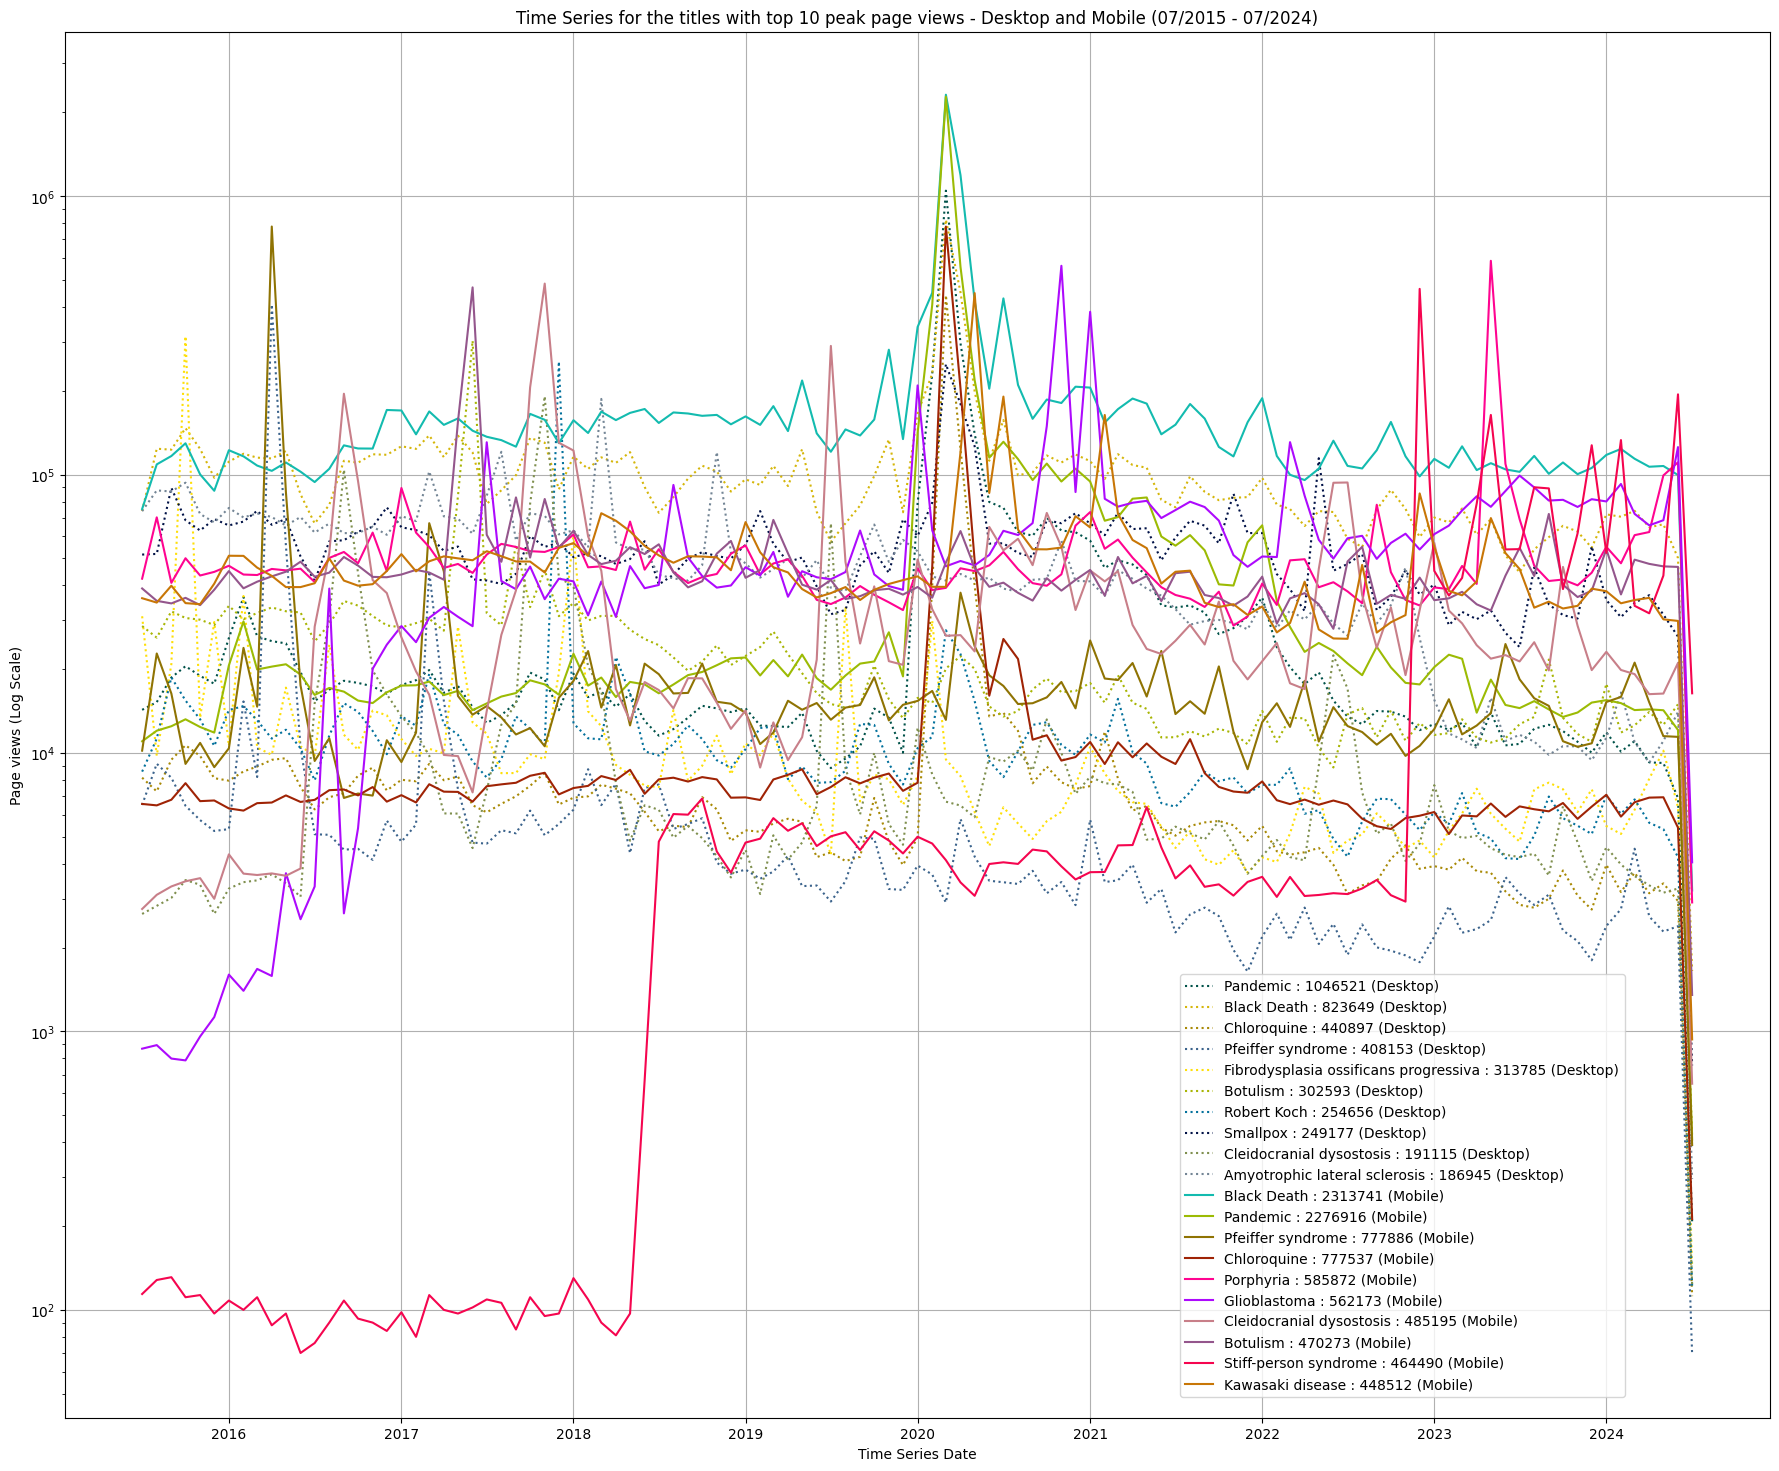

In [333]:
plt.figure(figsize=(22, 18))

# desktop top 10
for desktop_title in desktop_top_10:
    plt.plot([pd.to_datetime(item['timestamp'][:6], format='%Y%m') for item in monthly_desktop_access[desktop_title[0]]], 
            [item['views'] for item in monthly_desktop_access[desktop_title[0]]],  
            linestyle=':', 
            color=get_line_color(),
            label=f"{desktop_title[0]} : {desktop_title[1]} (Desktop)"
            )

# mobile top 10
for mobile_title in mobile_top_10:
    plt.plot([pd.to_datetime(item['timestamp'][:6], format='%Y%m') for item in monthly_mobile_access[mobile_title[0]]], 
            [item['views'] for item in monthly_mobile_access[mobile_title[0]]],  
            linestyle='-', 
            color=get_line_color(),
            label=f"{mobile_title[0]} : {mobile_title[1]} (Mobile)"
            )

plt.yscale('log')
# Labels and title
plt.xlabel('Time Series Date')
plt.ylabel('Page views (Log Scale)')
plt.title('Time Series for the titles with top 10 peak page views - Desktop and Mobile (07/2015 - 07/2024)')
plt.legend(loc='upper left', bbox_to_anchor=(0.65, 0.325))
plt.grid(True)
plt.savefig("top_10_desktop_mobile_logscale.png")
plt.show()

### Analyze titles with fewest month of data across timestamps for Desktop and Mobile accesses

In [321]:
desktop_months_of_data_per_title = {}
for title, views in monthly_desktop_access.items():
    months_of_data_title = 0
    for view in views:
        if view['views'] > 0:
            months_of_data_title+=1
    desktop_months_of_data_per_title[title] = months_of_data_title

desktop_fewest_10 = find_fewest_k_titles(desktop_top_views_per_title, 10)

mobile_months_of_data_per_title = {}
for title, views in monthly_mobile_access.items():
    months_of_data_title = 0
    for view in views:
        if view['views'] > 0:
            months_of_data_title+=1
    mobile_months_of_data_per_title[title] = months_of_data_title

mobile_fewest_10 = find_fewest_k_titles(mobile_months_of_data_per_title, 10)

In [322]:
desktop_fewest_10

[('Igan', 30),
 ('Juberg-Hayward syndrome', 35),
 ('Adaptive Physical Education Australia', 40),
 ('Joseph Vinetz', 44),
 ('Filippi Syndrome', 46),
 ('WNT4 deficiency', 46),
 ('Autosomal dominant porencephaly type I', 49),
 ('CDLS', 50),
 ('Primary anemia', 51),
 ('XPG N terminus', 52)]

In [323]:
mobile_fewest_10

[('Filippi Syndrome', 15),
 ('Bradley Monk', 27),
 ('Retinal vasculopathy with cerebral leukoencephalopathy and systemic manifestations',
  30),
 ('COVID-19 vaccine misinformation and hesitancy', 35),
 ('Spongy degeneration of the central nervous system', 38),
 ('CDKL5 deficiency disorder', 38),
 ('Joseph Vinetz', 38),
 ('Deaf plus', 39),
 ('Hemolytic jaundice', 39),
 ('Vence L. Bonham Jr.', 41)]

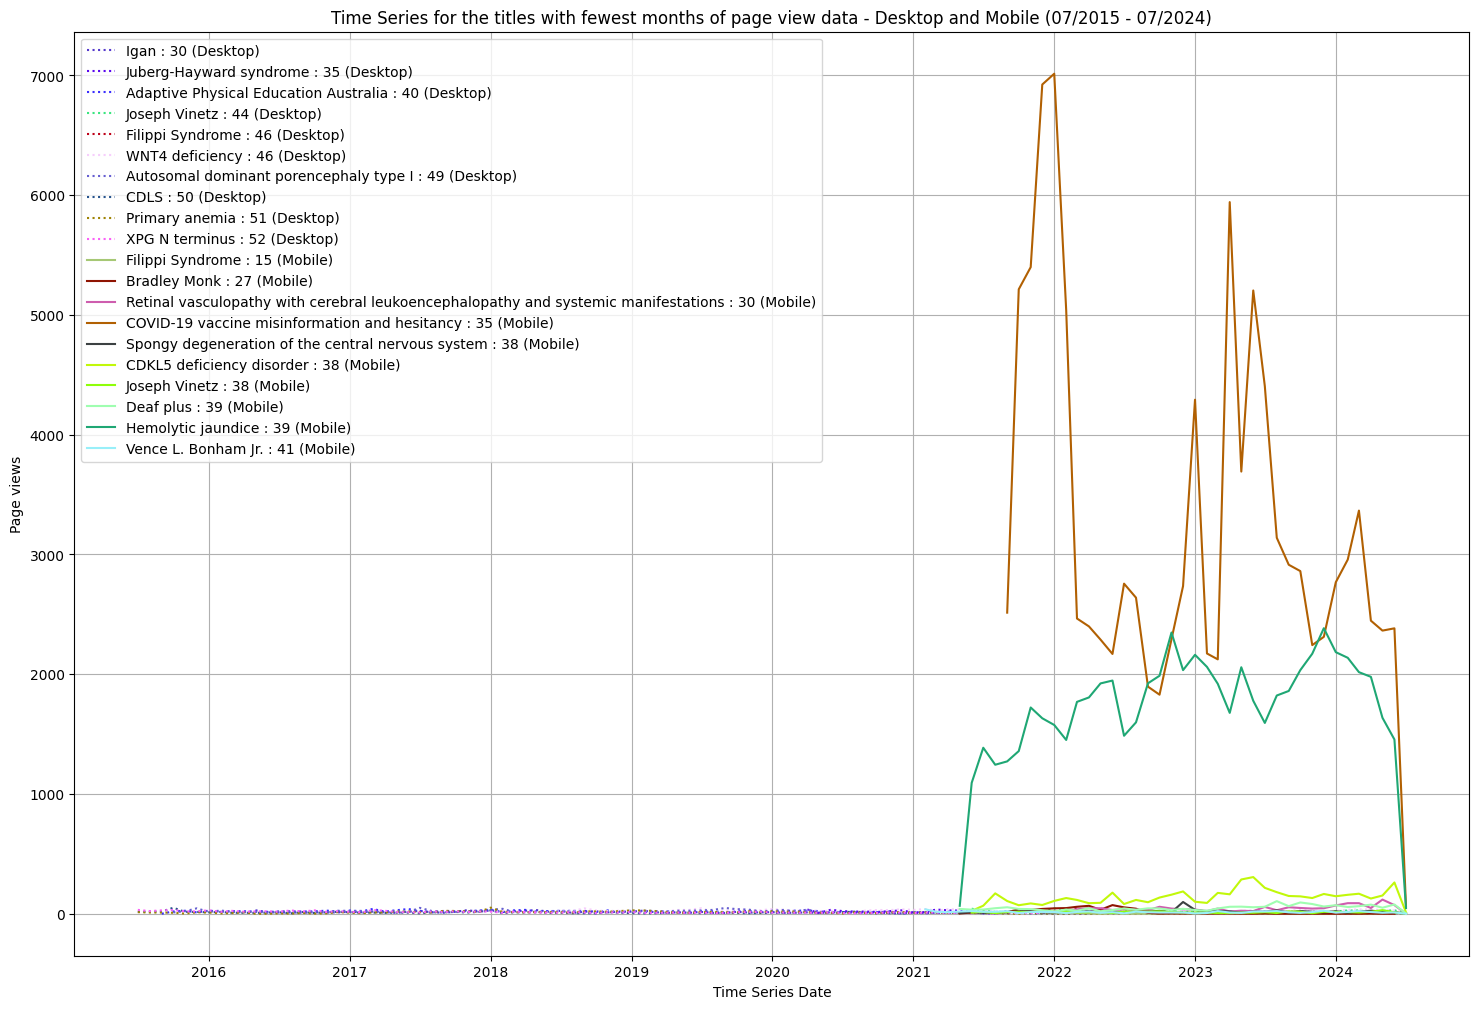

In [345]:
plt.figure(figsize=(18, 12))
used_colors = set()

# desktop fewest 10
for desktop_title in desktop_fewest_10:
    plt.plot([pd.to_datetime(item['timestamp'][:6], format='%Y%m') for item in monthly_desktop_access[desktop_title[0]]], 
            [item['views'] for item in monthly_desktop_access[desktop_title[0]]],  
            linestyle=':', 
            color=get_line_color(),
            label=f"{desktop_title[0]} : {desktop_title[1]} (Desktop)"
            )

# mobile fewest 10
for mobile_title in mobile_fewest_10:
    plt.plot([pd.to_datetime(item['timestamp'][:6], format='%Y%m') for item in monthly_mobile_access[mobile_title[0]]], 
            [item['views'] for item in monthly_mobile_access[mobile_title[0]]],  
            linestyle='-', 
            color=get_line_color(),
            label=f"{mobile_title[0]} : {mobile_title[1]} (Mobile)"
            )

# Labels and title
plt.xlabel('Time Series Date')
plt.ylabel('Page views')
plt.title('Time Series for the titles with fewest months of page view data - Desktop and Mobile (07/2015 - 07/2024)')
plt.legend()
plt.grid(True)
plt.savefig("fewest_months_10_desktop_mobile.png")
plt.show()